# Import Libraries


In [20]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from utils import flatten_datasets, fine_tune
from config import models

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Prepare Test Data

We prepare our test dataset by using the `test_set`. We ensure the same split as earlier since the seed value used in the other pipelines is the same.


In [21]:
flag = 1

base_model = models[flag]["base_model"]
model_name = models[flag]["model_name"]
num_layers_to_freeze = models[flag]["num_layers_to_freeze"]
config = models[flag]["config"]

In [22]:
data_dir = "dataset/2-cropped"
# test_dir = os.path.join(data_dir, "test")
class_names = os.listdir(data_dir)

train_set, test_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=config["seed_value"],
    image_size=config["img_shape"],
    batch_size=config["batch_size"],
    label_mode="binary",
    subset="both",
)

Found 447 files belonging to 2 classes.
Using 358 files for training.
Using 89 files for validation.


In [24]:
#print num, layers 
print(f"Number of layers in the base model: {len(base_model.layers)}")


Number of layers in the base model: 230


In [23]:
data_dir = "dataset/2-cropped"
# test_dir = os.path.join(data_dir, "test")
class_names = os.listdir(data_dir)

train_set, test_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=config["seed_value"],
    image_size=config["img_shape"],
    batch_size=config["batch_size"],
    label_mode="binary",
    subset="both",
)

train_images, train_labels = flatten_datasets(train_set)
test_images, test_labels = flatten_datasets(test_set)

# all_images = np.concatenate((train_images, test_images))
# all_labels = np.concatenate((train_labels, test_labels)).argmax(axis=1).tolist()

# # shuffle all images and labels
# all_images, all_labels = tf.random.shuffle(all_images), tf.random.shuffle(all_labels)

# healthy_images, healthy_labels = [], []
# wssv_images, wssv_labels = [], []
# for i, label in enumerate(all_labels):
#     if label == 0 and len(healthy_images) < 10:
#         healthy_images.append(all_images[i])
#         healthy_labels.append(i)

#     if label == 1 and len(wssv_images) < 10:
#         wssv_images.append(all_images[i])
#         wssv_labels.append(i)

Found 447 files belonging to 2 classes.
Using 358 files for training.
Using 89 files for validation.


TypeError: only integer scalar arrays can be converted to a scalar index

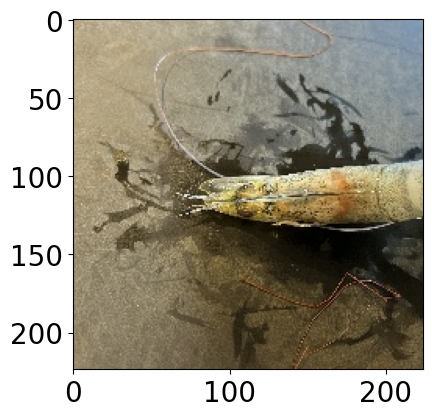

In [26]:
# get 4 images of each class and plot


In [124]:
ul = 150
ll = 50

train_images = train_images[ll:ul]
train_labels = train_labels[ll:ul]

# # filter out, only get images in index [5,22,34,45]
# train_images = train_images[[5, 22, 34, 45]]
# train_labels = train_labels[[5, 22, 34, 45]]

replace2linear = ReplaceToLinear()
X = np.asarray(test_images.astype(np.float32))

test_labels = test_labels.astype(np.int32).flatten().tolist()
score = CategoricalScore(test_labels)

# Defining the Base Model

This project will be using EfficientNetV2-B0 and MobileNetV3-Small. We can easily get this from the TensorFlow API. Let's set a `flag` variable so we can easily set which model we want to test with.


In [125]:
fold = 3
# mobilenet fold 2; efficient 4
checkpoints_path = f"checkpoints/{model_name}/fold_{fold}"
# checkpoints_path = f"checkpoints/fine-tune/{model_name}"

latest_checkpoint = tf.train.latest_checkpoint(checkpoints_path)
model = fine_tune(base_model, config, num_layers_to_freeze)
model.load_weights(latest_checkpoint)

# Prepare Grad-CAM++


In [126]:
gradcam = GradcamPlusPlus(
    model.get_layer(model_name),
    model_modifier=replace2linear,
    clone=True,
)

cam = gradcam(score, X, penultimate_layer=-1)

In [127]:
predictions = model.predict(test_images)
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1).numpy().flatten()

# plt.figure(figsize=(30, 30), dpi=150)
# fig, ax = plt.subplots(1, 10, figsize=(15, 15), dpi=150)

# get only healthy images and index in the variable cam
# healthy_images, healthy_labels = [], []
# wssv_images, wssv_labels = [], []
# for i, label in enumerate(test_labels):
#     if label == 0:
#         healthy_images.append(test_images[i])
#         healthy_labels.append(i)

#     if label == 1:
#         wssv_images.append(test_images[i])
#         wssv_labels.append(i)

# j = 1
# plt.figure(figsize=(30, 30), dpi=600)
# for i, index in enumerate(train_labels):
#     if index == 1 and j <= 4:
#         plt.subplot(1, 10, j)
#         # plt.subplot(1, 4, j)
#         j += 1
#         heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
#         # put prediction and true label on top of image, then highlight it red if wrong prediction
#         misclassified = predictions[i] != index
#         if misclassified:
#             plt.title(
#                 f"Prediction: {class_names[predictions[i]]}\n True label: {class_names[index]}",
#                 color="red",
#             )
#         else:
#             plt.title(
#                 f"Prediction: {class_names[predictions[i]]}\n True label: {class_names[index]}"
#             )

#         plt.imshow(train_images[i] / 255)
#         plt.imshow(heatmap, cmap="jet", alpha=0.25)
#         plt.axis("off")

#     if i == ul - ll:
#         break

# # for i, index in enumerate(wssv_labels):
# #     heatmap = np.uint8(cm.jet(cam[index])[..., :3] * 255)

# #     ax[1, i].imshow(wssv_images[i] / 255)
# #     ax[1, i].imshow(heatmap, cmap="jet", alpha=0.25)
# #     ax[1, i].axis("off")

# #     if i == 4:
# #         break

# plt.tight_layout()
# plt.show()

3/3 [==============================] - 1s 131ms/step


<Figure size 4500x4500 with 0 Axes>

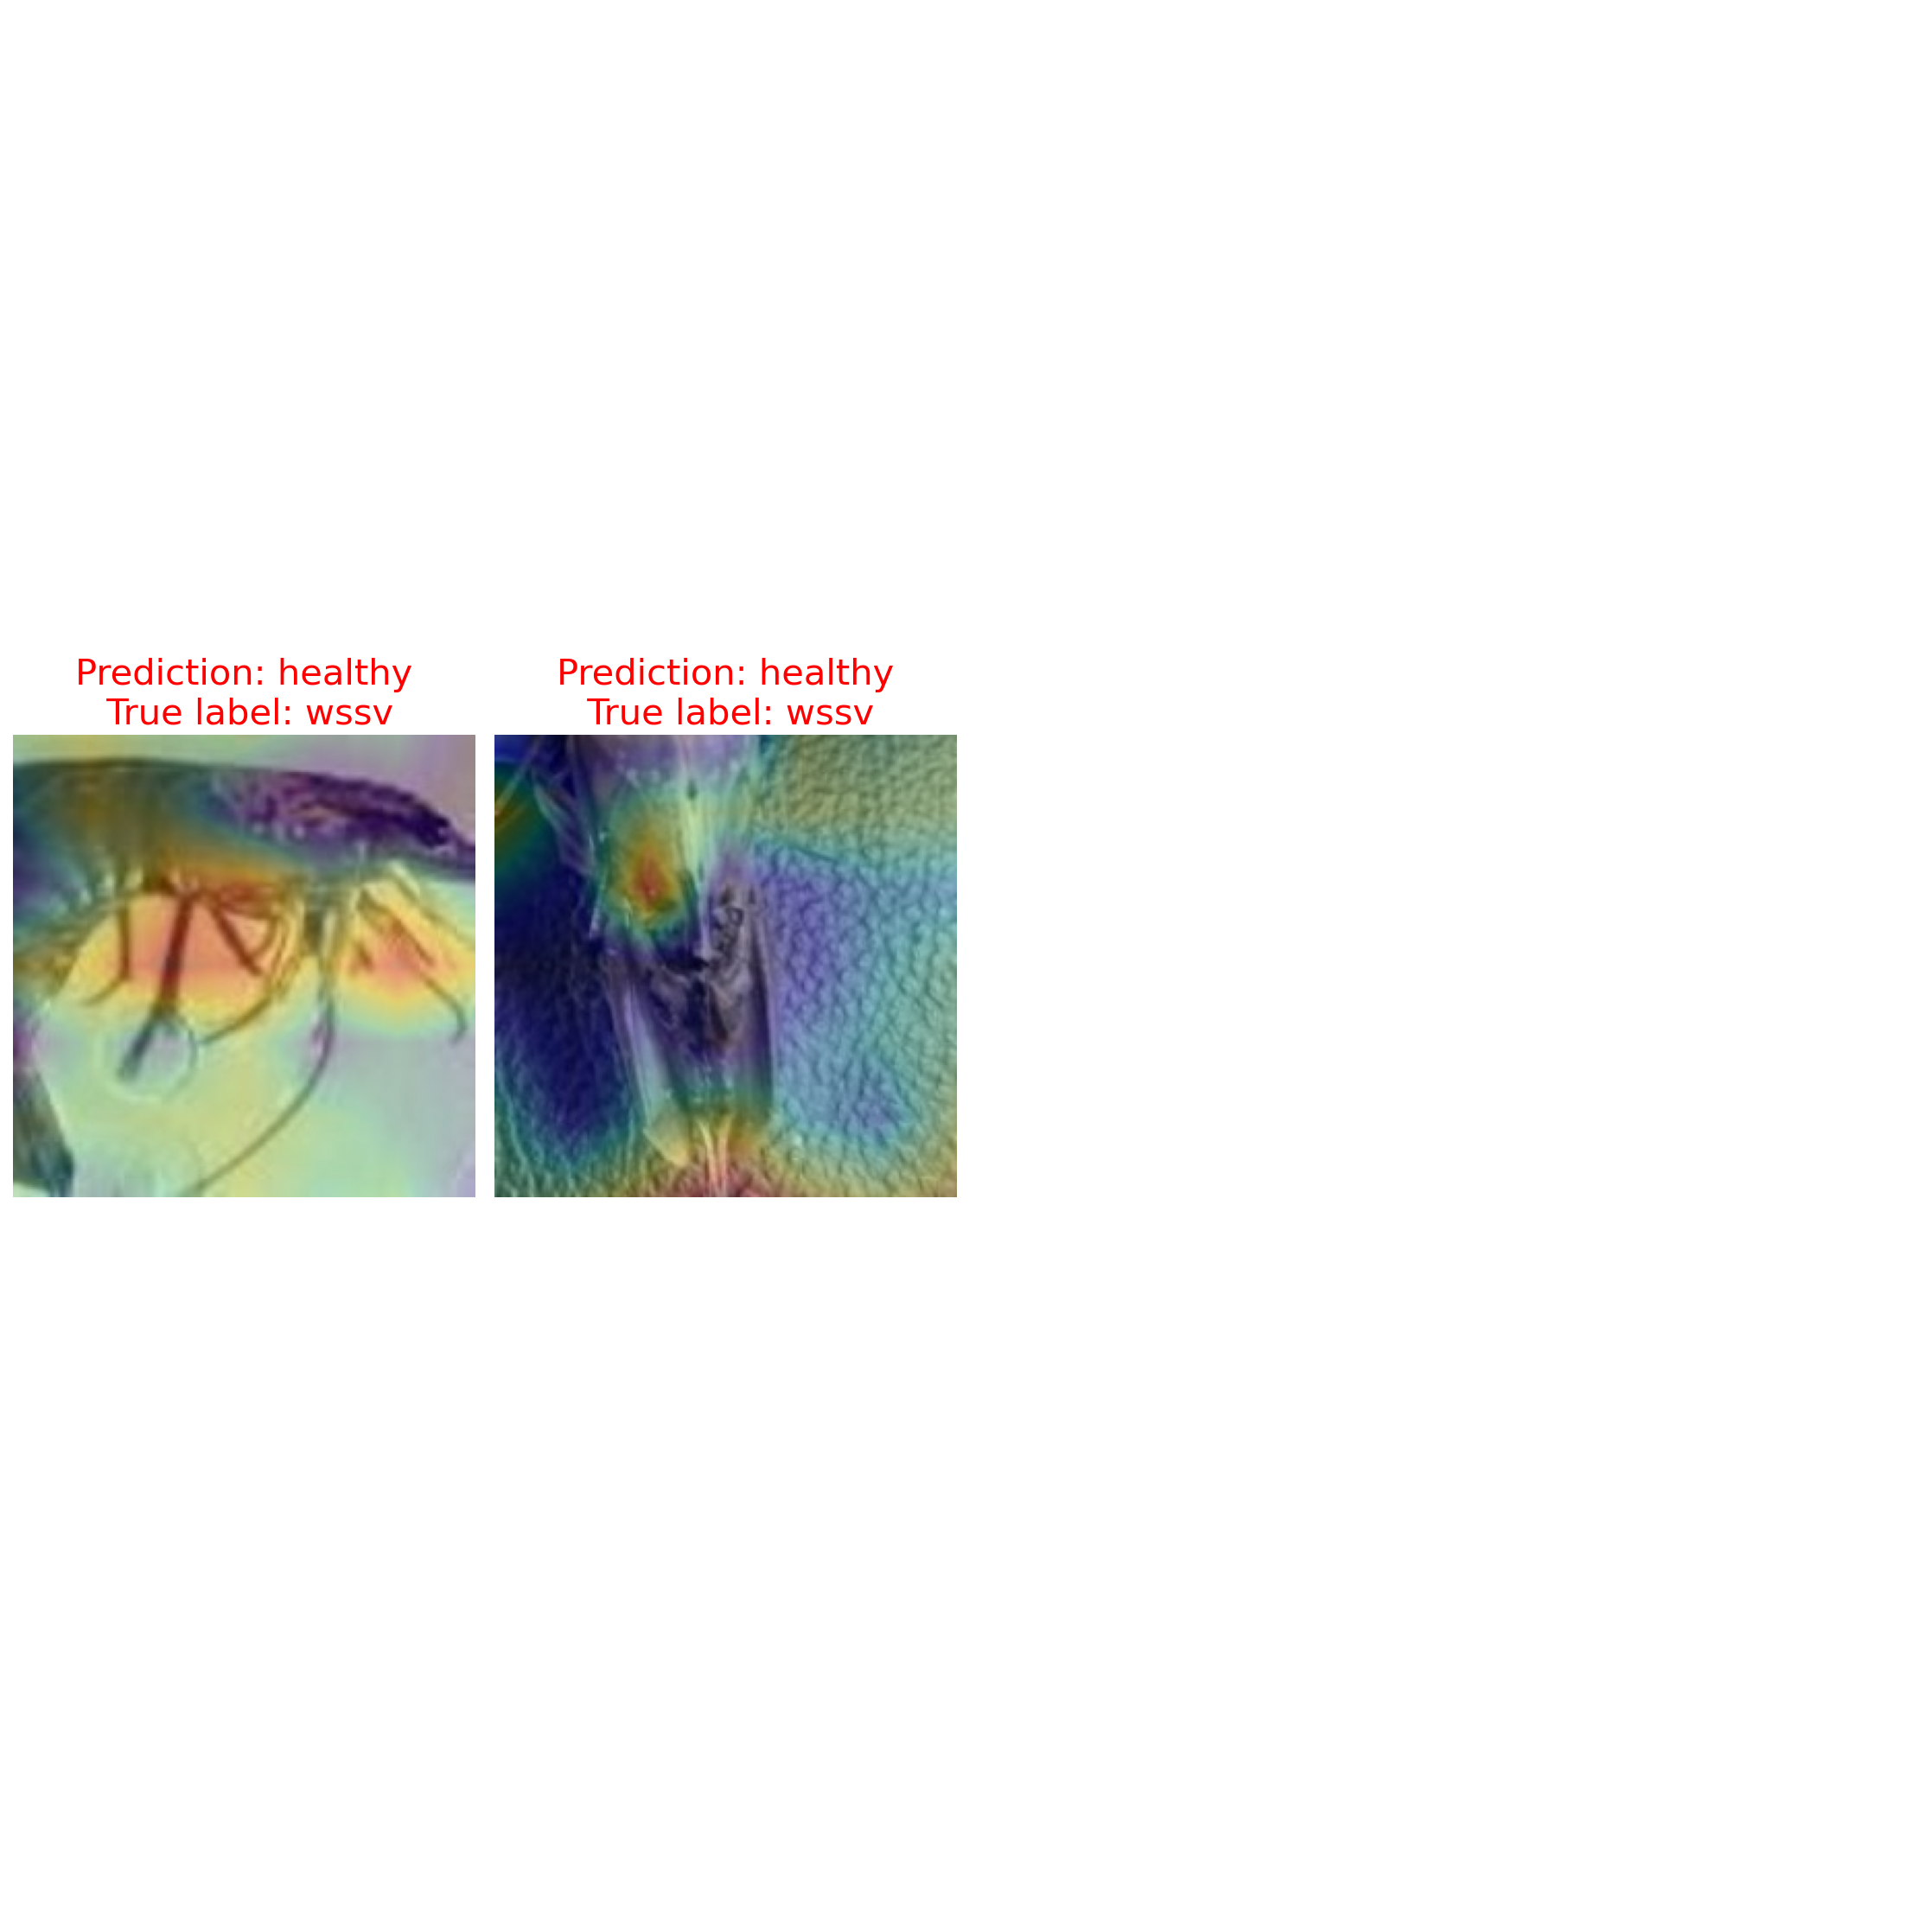

In [128]:
# get only misclassified images
misclassified_images, misclassified_labels = [], []
for i, label in enumerate(test_labels):
    if label != predictions[i]:
        misclassified_images.append(test_images[i])
        misclassified_labels.append(i)

plt.figure(figsize=(30, 30), dpi=150)
fig, ax = plt.subplots(1, 4, figsize=(15, 15), dpi=150)

for i, index in enumerate(misclassified_labels):
    heatmap = np.uint8(cm.jet(cam[index])[..., :3] * 255)

    ax[i].imshow(misclassified_images[i] / 255)
    ax[i].imshow(heatmap, cmap="jet", alpha=0.25)
    ax[i].axis("off")

    # title
    ax[i].set_title(
        f"Prediction: {class_names[predictions[index]]}\n True label: {class_names[test_labels[index]]}",
        color="red",
        fontsize=20,
    )

    if i == 2:
        break
    
ax[2].axis('off')
ax[3].axis('off')


plt.tight_layout()
plt.show()

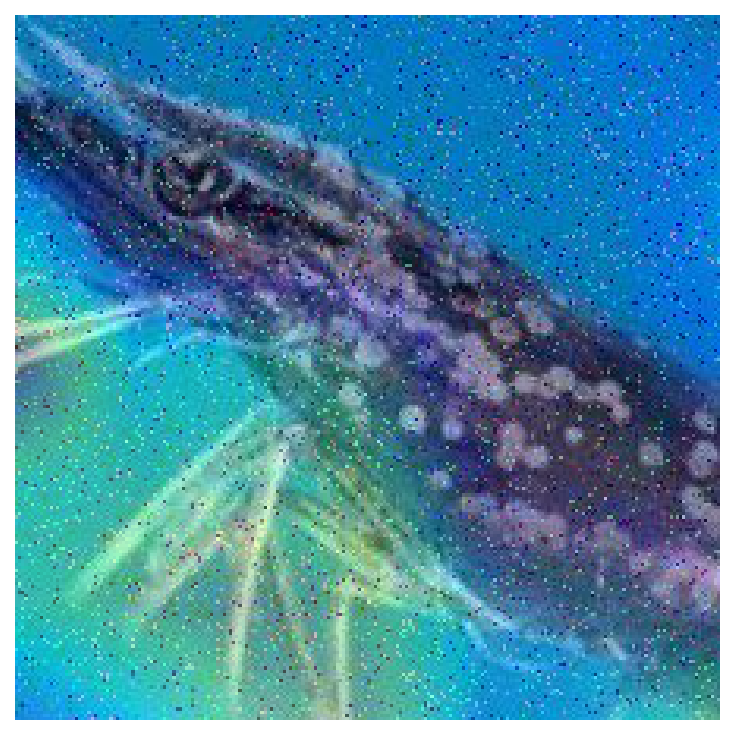

In [129]:
filename = "dataset/wssv_noise.jpg"
image = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))

gradcam = GradcamPlusPlus(
    model.get_layer(model_name),
    model_modifier=replace2linear,
    clone=True,
)

images = np.asarray([np.array(image).astype(np.float32)])
score = CategoricalScore([1])
cam = gradcam(score, images, penultimate_layer=-1)

plt.figure(figsize=(5, 5), dpi=150)
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(images[0] / 255)
plt.imshow(heatmap, cmap="jet", alpha=0.25)  # overlay
plt.axis("off")
plt.tight_layout()
plt.show()